In [21]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# MNIST dataset (28x28 images of digits 0-9)
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', download=True, transform=transforms.ToTensor()), # download and transform to tensor
    batch_size=64, shuffle=True
)

In [22]:
# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Using device: {device}')

Using device: cuda


In [23]:
# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, dim_latent_space=5):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, dim_latent_space)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(dim_latent_space, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 784),
            nn.Sigmoid()  # to ensure output is between 0 and 1
        )

    # Encode to Latent Space
    def encode(self, x):
        z = self.encoder(x)
        return z

    # Decode to original space
    def decode(self, z):
        x_hat = self.decoder(z)
        return x_hat

    # Forward pass through the network
    def forward(self, x):
        z = self.encode(x)      # pass through encoder
        x_hat = self.decode(z)  # pass through decoder
        return x_hat, z

# Hyperparameters
dim_latent_space = 5
learning_rate = 1e-4
num_epochs = 20
lambda_reg = 1e-4  # latent regularization strength

# Instantiate model
model = Autoencoder(dim_latent_space)

# Move model to GPU if available
model.to(device)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [24]:

# Training loop
for epoch in range(num_epochs):

    total_recon_loss = 0.0
    total_reg_loss = 0.0

    # Train for one epoch
    for imgs, _ in train_loader:

        imgs = imgs.view(imgs.size(0), -1)       # flatten 28×28 to 784
        imgs = imgs.to(device)                   # move to GPU if available

        # Forward pass
        outputs, z = model(imgs)                    # forward pass

        # reconstruction loss
        recon_loss = criterion(outputs, imgs)
        
        # latent regularization loss
        reg_loss = lambda_reg * torch.mean(torch.sum(z**2, dim=1))

        # Total loss
        loss = recon_loss + reg_loss

        optimizer.zero_grad()   # clear old gradients
        loss.backward()         # backpropagation
        optimizer.step()        # update model parameters

        # Accumulate losses
        total_recon_loss += recon_loss.item() * imgs.size(0)
        total_reg_loss += reg_loss.item() * imgs.size(0)

    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_reg_loss = total_reg_loss / len(train_loader.dataset)

    # Print loss every epoch
    print(f"Epoch {epoch+1}/{num_epochs}, "
        f"Recon Loss: {avg_recon_loss:.4f}, "
        f"Reg Loss: {avg_reg_loss:.6f}, "
        f"Total Loss: {avg_recon_loss + avg_reg_loss:.4f}")


Epoch 1/20, Recon Loss: 0.0827, Reg Loss: 0.002826, Total Loss: 0.0855
Epoch 2/20, Recon Loss: 0.0520, Reg Loss: 0.000983, Total Loss: 0.0530
Epoch 3/20, Recon Loss: 0.0433, Reg Loss: 0.001004, Total Loss: 0.0443
Epoch 4/20, Recon Loss: 0.0392, Reg Loss: 0.000978, Total Loss: 0.0402
Epoch 5/20, Recon Loss: 0.0374, Reg Loss: 0.000907, Total Loss: 0.0383
Epoch 6/20, Recon Loss: 0.0361, Reg Loss: 0.000856, Total Loss: 0.0370
Epoch 7/20, Recon Loss: 0.0351, Reg Loss: 0.000811, Total Loss: 0.0359
Epoch 8/20, Recon Loss: 0.0344, Reg Loss: 0.000765, Total Loss: 0.0351
Epoch 9/20, Recon Loss: 0.0337, Reg Loss: 0.000724, Total Loss: 0.0345
Epoch 10/20, Recon Loss: 0.0332, Reg Loss: 0.000692, Total Loss: 0.0339
Epoch 11/20, Recon Loss: 0.0327, Reg Loss: 0.000667, Total Loss: 0.0334
Epoch 12/20, Recon Loss: 0.0323, Reg Loss: 0.000647, Total Loss: 0.0329
Epoch 13/20, Recon Loss: 0.0319, Reg Loss: 0.000630, Total Loss: 0.0325
Epoch 14/20, Recon Loss: 0.0315, Reg Loss: 0.000613, Total Loss: 0.0322
E

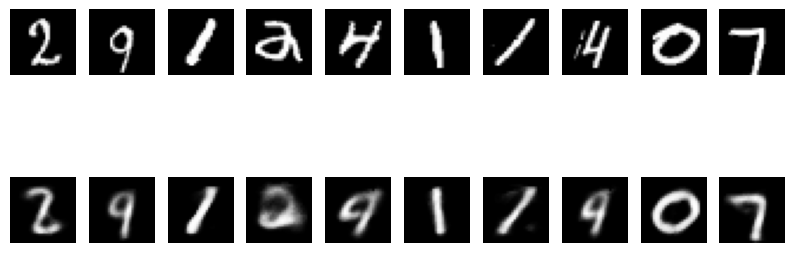

In [26]:
import matplotlib.pyplot as plt

# Get one batch
imgs, _ = next(iter(train_loader))
imgs = imgs.view(imgs.size(0), -1).to(device)  # Move to GPU

# Get reconstructions
with torch.no_grad():
    reconstruction, _ = model(imgs)  # unpack tuple

# Move back to CPU for plotting
imgs = imgs.cpu()
reconstruction = reconstruction.cpu()

# Show original and reconstructed images
num_tests = 10
plt.figure(figsize=(10, 4))
for i in range(num_tests):
    # Original
    ax = plt.subplot(2, num_tests, i + 1)
    plt.imshow(imgs[i].view(28, 28), cmap="gray")
    plt.axis("off")
    
    # Reconstruction
    ax = plt.subplot(2, num_tests, i + 1 + num_tests)
    plt.imshow(reconstruction[i].view(28, 28), cmap="gray")
    plt.axis("off")

plt.show()
